# Breast Cancer Classification with DenseNet121 + Speckle2Self
## Deep Learning - Individual Assignment

**Student:** Naga Billy  
**Model:** DenseNet121  
**Preprocessing:** Speckle2Self (Denoising)  
**Dataset:** BUSI + Mendeley (Combined)  
**Classes:** Benign, Malignant, Normal  

---

## 1. Setup & Import Libraries

In [1]:
import os
import gc
from PIL import Image
import glob
import shutil
import itertools
import time
import random
import logging
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import cv2
import math
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchvision.models import densenet201, DenseNet201_Weights
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️  Using device: cpu


## 2. Configuration

In [3]:
# ========================================
# MAIN CONFIGURATION
# ========================================
DATASET_PATH = '../Combined_dataset'  # Adjust this path
CLASSES = ['benign', 'malignant', 'normal']
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
SPLIT_TRAIN = 0.8
SPLIT_VAL = 0.1
SPLIT_TEST = 0.1
DROPOUT_RATE = 0.5
L2_RATE = 0.001
FREEZE_PERCENTAGE = 0.1  # Last 10% layers unfrozen
RANDOM_SEED = 42

# ========================================
# AUGMENTATION CONFIG
# ========================================
AUG_ROTATION = 0
AUG_H_FLIP = True
AUG_V_FLIP = False
AUG_ZOOM = 0
AUG_W_SHIFT = 0.05
AUG_H_SHIFT = 0.05
AUG_FILL_MODE = 'nearest'

# ========================================
# PREPROCESSING CONFIG
# ========================================
# NOTE: CLAHE disabled by default (requested).
USE_CLAHE = False
CLAHE_CLIP = 2
CLAHE_GRID = (8, 8)

# ========================================
# PREPROCESSING CONFIG (Speckle2Self)
# ========================================
# Ref: https://github.com/noseefood/speckle2self
S2S_ENABLED = True
S2S_REPO_DIR = './speckle2self'
S2S_MODEL_PATH = './model_2833.pth'
S2S_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S2S_USE_CACHE = True
S2S_CACHE_DIR = './cache/speckle2self'

# ========================================
# TRAINING CONFIG
# ========================================
EARLY_STOPPING_PATIENCE = 10
NUM_WORKERS = 4

print("✅ Configuration Loaded.")
print(f"📊 Model: DenseNet201")
print(f"🔧 Preprocessing: Speckle2Self (enabled={S2S_ENABLED})")
print(f"🔧 Preprocessing: CLAHE (enabled={USE_CLAHE})")
if USE_CLAHE:
    print(f"   - CLAHE clip={CLAHE_CLIP}, grid={CLAHE_GRID}")
print(f"📦 Batch Size: {BATCH_SIZE}")
print(f"🔄 Epochs: {EPOCHS}")
print(f"📏 Image Size: {IMG_SIZE}")
print(f"🎯 Classes: {CLASSES}")

✅ Configuration Loaded.
📊 Model: DenseNet201
🔧 Preprocessing: Speckle2Self (enabled=True)
🔧 Preprocessing: CLAHE (enabled=False)
📦 Batch Size: 32
🔄 Epochs: 50
📏 Image Size: (224, 224)
🎯 Classes: ['benign', 'malignant', 'normal']


In [4]:
# ========================================
# Speckle2Self setup (optional)
# ========================================
# This cell helps you fetch the reference repo for Speckle2Self.
# It will NOT clone/install unless you set S2S_AUTO_INSTALL=True.

import sys
import subprocess
from pathlib import Path

S2S_REPO_URL = 'https://github.com/noseefood/speckle2self'
S2S_AUTO_INSTALL = False  # set True if you want this cell to clone + pip install automatically

def ensure_speckle2self_repo(repo_dir: str = S2S_REPO_DIR, auto_install: bool = S2S_AUTO_INSTALL) -> bool:
    repo_path = Path(repo_dir)
    if repo_path.exists():
        repo_abs = str(repo_path.resolve())
        if repo_abs not in sys.path:
            sys.path.insert(0, repo_abs)
        print(f"✅ speckle2self repo ready: {repo_abs}")
        return True
    
    if not auto_install:
        print("ℹ️ speckle2self repo not found.")
        print(f"   - Expected at: {repo_path.resolve()}")
        print(f"   - Clone manually: git clone {S2S_REPO_URL} {repo_dir}")
        print("   - Or set S2S_AUTO_INSTALL=True and re-run this cell")
        return False
    
    print("⬇️  Cloning speckle2self...")
    subprocess.check_call(['git', 'clone', S2S_REPO_URL, str(repo_path)])
    print("📦 Installing requirements... (this may take a few minutes)")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', str(repo_path / 'requirements.txt')])
    repo_abs = str(repo_path.resolve())
    if repo_abs not in sys.path:
        sys.path.insert(0, repo_abs)
    print(f"✅ speckle2self installed and ready: {repo_abs}")
    return True

_speckle2self_ok = ensure_speckle2self_repo()

✅ speckle2self repo ready: F:\Kuliah Salsa\Humic\salsabila_humic\salsabila_humic\Speckle-Preprocessing-USG\speckle2self


In [5]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed, workers=True)

set_seed(RANDOM_SEED)
print(f"✅ Random seed set to {RANDOM_SEED}")

Seed set to 42


✅ Random seed set to 42


## 3. Dataset Preparation

### 3.1 Load and Merge Datasets

Menggabungkan dua dataset:
1. **BUSI Dataset**: 780 images (437 benign, 210 malignant, 133 normal)
2. **Mendeley Dataset**: 250 images (100 benign, 150 malignant)

**Total**: ~1030 images across 3 classes

In [6]:
print("📂 Collecting image paths...")
image_paths = []
labels = []

for cls in CLASSES:
    class_folder = os.path.join(DATASET_PATH, cls)
    
    if not os.path.exists(class_folder):
        print(f"⚠️  Folder {class_folder} not found, skipping...")
        continue
    
    for image_name in os.listdir(class_folder):
        # Skip mask files
        if 'mask' not in image_name.lower():
            image_path = os.path.join(class_folder, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(cls)

print(f"✅ Collected {len(image_paths)} images")

📂 Collecting image paths...
✅ Collected 1030 images


In [7]:
# Shuffle and encode labels
image_paths, labels = shuffle(image_paths, labels, random_state=RANDOM_SEED)

# Label encoding
unique_labels = np.unique(labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
y_labels = np.array([label_to_index[i] for i in labels])
num_classes = len(unique_labels)

print(f"\n{'='*50}")
print(f"{'DATASET SUMMARY':^50}")
print(f"{'='*50}")
print(f"Total images: {len(image_paths)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {list(unique_labels)}")
print(f"\nLabel encoding:")
for label, idx in label_to_index.items():
    count = np.sum(y_labels == idx)
    print(f"  {label}: {idx} ({count} images, {count/len(y_labels)*100:.1f}%)")
print(f"{'='*50}\n")


                 DATASET SUMMARY                  
Total images: 1030
Number of classes: 3
Classes: [np.str_('benign'), np.str_('malignant'), np.str_('normal')]

Label encoding:
  benign: 0 (537 images, 52.1%)
  malignant: 1 (360 images, 35.0%)
  normal: 2 (133 images, 12.9%)



### 3.2 Data Splitting

Split ratio:
- **Train**: 80% (dari total)
- **Validation**: 10% (dari total, diambil dari train)
- **Test**: 10% (dari total)

In [8]:
# Split: 80% train+val, 10% test
paths_trainval, paths_test, y_trainval, y_test = train_test_split(
    image_paths, y_labels, 
    test_size=SPLIT_TEST, 
    random_state=RANDOM_SEED, 
    stratify=y_labels
)

# Split train+val: 80% train (from total), 10% val (from total)
# validation will be 10/(80+10) = 11.11% of trainval
val_ratio = SPLIT_VAL / (SPLIT_TRAIN + SPLIT_VAL)
paths_train, paths_val, y_train, y_val = train_test_split(
    paths_trainval, y_trainval,
    test_size=val_ratio,
    random_state=RANDOM_SEED,
    stratify=y_trainval
)

print(f"\n{'='*60}")
print(f"{'DATA SPLITTING SUMMARY':^60}")
print(f"{'='*60}")
print(f"Total Data      : {len(image_paths)}")
print(f"Data Training   : {len(paths_train)} ({len(paths_train)/len(image_paths)*100:.1f}%)")
print(f"Data Validation : {len(paths_val)} ({len(paths_val)/len(image_paths)*100:.1f}%)")
print(f"Data Testing    : {len(paths_test)} ({len(paths_test)/len(image_paths)*100:.1f}%)")
print(f"-" * 60)

# Class distribution
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    print(f"\n[{split_name} Set]")
    for label, idx in label_to_index.items():
        count = np.sum(y_split == idx)
        print(f"  {label.capitalize():12s}: {count:3d} ({count/len(y_split)*100:.1f}%)")

print(f"{'='*60}\n")


                   DATA SPLITTING SUMMARY                   
Total Data      : 1030
Data Training   : 823 (79.9%)
Data Validation : 104 (10.1%)
Data Testing    : 103 (10.0%)
------------------------------------------------------------

[Train Set]
  Benign      : 429 (52.1%)
  Malignant   : 288 (35.0%)
  Normal      : 106 (12.9%)

[Validation Set]
  Benign      :  54 (51.9%)
  Malignant   :  36 (34.6%)
  Normal      :  14 (13.5%)

[Test Set]
  Benign      :  54 (52.4%)
  Malignant   :  36 (35.0%)
  Normal      :  13 (12.6%)



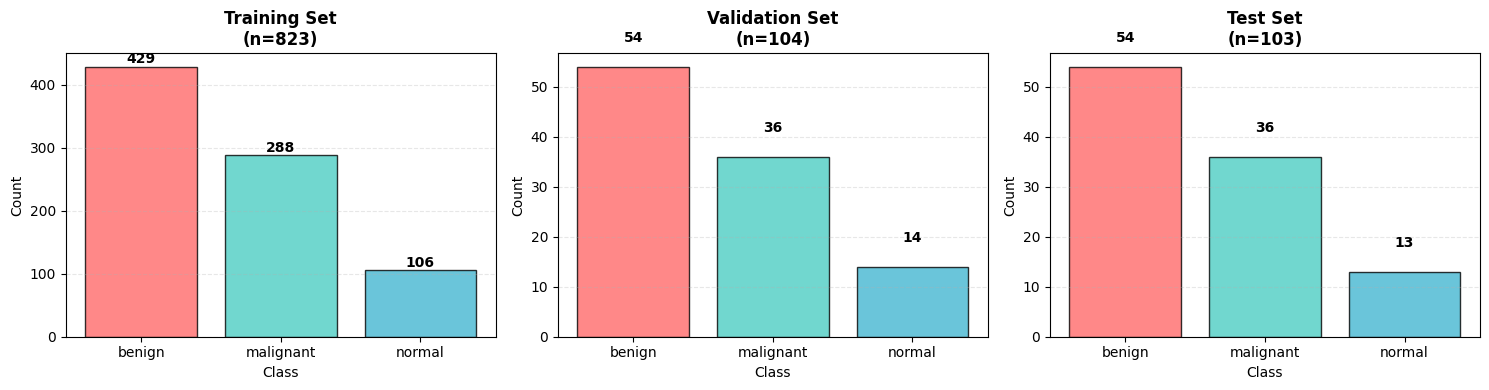

✅ Data distribution visualization saved as 'data_distribution.png'


In [9]:
# Visualize data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
splits = [
    ("Training Set", y_train),
    ("Validation Set", y_val),
    ("Test Set", y_test)
]

for idx, (title, y_data) in enumerate(splits):
    counts = [np.sum(y_data == i) for i in range(num_classes)]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    axes[idx].bar(CLASSES, counts, color=colors, alpha=0.8, edgecolor='black')
    axes[idx].set_title(f"{title}\n(n={len(y_data)})", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, v in enumerate(counts):
        axes[idx].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Data distribution visualization saved as 'data_distribution.png'")

## 4. Preprocessing (Speckle2Self)

Pipeline preprocessing yang digunakan:

- **Speckle2Self**: denoising speckle pada citra ultrasound (self-supervised).
- **Urutan pipeline**: Speckle2Self → transforms/normalization.

Parameter ada di konfigurasi: `S2S_*`.

In [10]:
def apply_clahe(image, clip_limit=CLAHE_CLIP, tile_grid_size=CLAHE_GRID):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    
    Args:
        image: Input image (numpy array or PIL Image)
        clip_limit: Threshold for contrast limiting
        tile_grid_size: Size of grid for histogram equalization
    
    Returns:
        CLAHE-processed image
    """
    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(gray)
    
    # Convert back to RGB for consistency
    enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    
    return Image.fromarray(enhanced_rgb)

print("✅ CLAHE preprocessing function defined")

✅ CLAHE preprocessing function defined


In [11]:
# ========================================
# Speckle2Self preprocessing helper
# ========================================
import hashlib

_S2S_MODEL = None
_S2S_MODEL_LOADED_FROM = None

def _load_speckle2self_model():
    """Lazy-load Speckle2Self model from the reference repo."""
    global _S2S_MODEL, _S2S_MODEL_LOADED_FROM
    if _S2S_MODEL is not None:
        return _S2S_MODEL
    
    if not S2S_ENABLED:
        raise RuntimeError("Speckle2Self is disabled (S2S_ENABLED=False)")
    
    repo_ok = ensure_speckle2self_repo()
    if not repo_ok:
        raise RuntimeError(
            "speckle2self repo is not available. Run the Speckle2Self setup cell or clone it manually."
        )
    
    model_path = Path(S2S_MODEL_PATH)
    if not model_path.exists():
        raise FileNotFoundError(
            f"Speckle2Self checkpoint not found: {model_path.resolve()}\n"
            "Set S2S_MODEL_PATH to a compatible .pth checkpoint."
        )
    
    # Import after sys.path is ready (from the cloned repo)
    from networks.srn.net import SpeckleReductionNet
    from utils.image_ops import linear_normalization  # noqa: F401
    
    model = SpeckleReductionNet().to(S2S_DEVICE)
    checkpoint = torch.load(str(model_path), map_location=S2S_DEVICE)
    # The repo's inference uses strict=False; keep the same to maximize compatibility
    model.load_state_dict(checkpoint, strict=False)
    model.eval()
    _S2S_MODEL = model
    _S2S_MODEL_LOADED_FROM = str(model_path.resolve())
    print(f"✅ Speckle2Self model loaded: {_S2S_MODEL_LOADED_FROM}")
    return _S2S_MODEL

def _s2s_cache_key(img_path: str | None, size: tuple[int, int]) -> str:
    base = f"{img_path}|{size}|{S2S_MODEL_PATH}"
    return hashlib.sha1(base.encode('utf-8')).hexdigest()

def apply_speckle2self(image: Image.Image, img_path: str | None = None) -> Image.Image:
    """
    Apply Speckle2Self denoising. Expects a PIL RGB image and returns PIL RGB image.
    Internally converts to grayscale because the reference model is 1-channel.
    """
    if not isinstance(image, Image.Image):
        raise TypeError("apply_speckle2self expects a PIL.Image")
    
    # Cache (optional)
    if S2S_USE_CACHE and S2S_CACHE_DIR:
        os.makedirs(S2S_CACHE_DIR, exist_ok=True)
        key = _s2s_cache_key(img_path, IMG_SIZE)
        cache_file = Path(S2S_CACHE_DIR) / f"{key}.png"
        if cache_file.exists():
            cached = Image.open(cache_file).convert('L')
            cached_rgb = cached.convert('RGB')
            return cached_rgb
    else:
        cache_file = None
    
    # Convert to grayscale uint8 [0..255]
    gray_u8 = np.array(image.convert('L'), dtype=np.uint8)
    
    # Normalize to [0,1] using repo's helper
    from utils.image_ops import linear_normalization
    norm = linear_normalization(gray_u8).astype(np.float32)
    
    # Model inference (matches speckle2self/inference.py: output_tensor, _, _ = model(...))
    model = _load_speckle2self_model()
    with torch.no_grad():
        t = torch.from_numpy(norm).unsqueeze(0).unsqueeze(0).to(S2S_DEVICE)  # (1,1,H,W)
        out_pack = model(t, t, t)
        out_tensor = out_pack[0] if isinstance(out_pack, (tuple, list)) else out_pack
        out_tensor = torch.clamp(out_tensor, 0, 1)
        out = out_tensor.squeeze().detach().cpu().numpy()
    
    # Apply gamma correction for better visual quality (default gamma=1.5 as per repo)
    # This helps smooth transitions and makes dark regions blend naturally
    out = np.clip(out, 0.0, 1.0)
    gamma = 1.5
    out_gamma = np.power(out, gamma)
    out_u8 = (out_gamma * 255.0).astype(np.uint8)
    
    # Convert to PIL Image (grayscale first, then RGB)
    out_pil = Image.fromarray(out_u8, mode='L')
    
    if cache_file is not None:
        out_pil.save(cache_file)
    
    # Convert grayscale to RGB properly
    out_rgb = out_pil.convert('RGB')
    return out_rgb

print("✅ Speckle2Self helper defined")

✅ Speckle2Self helper defined


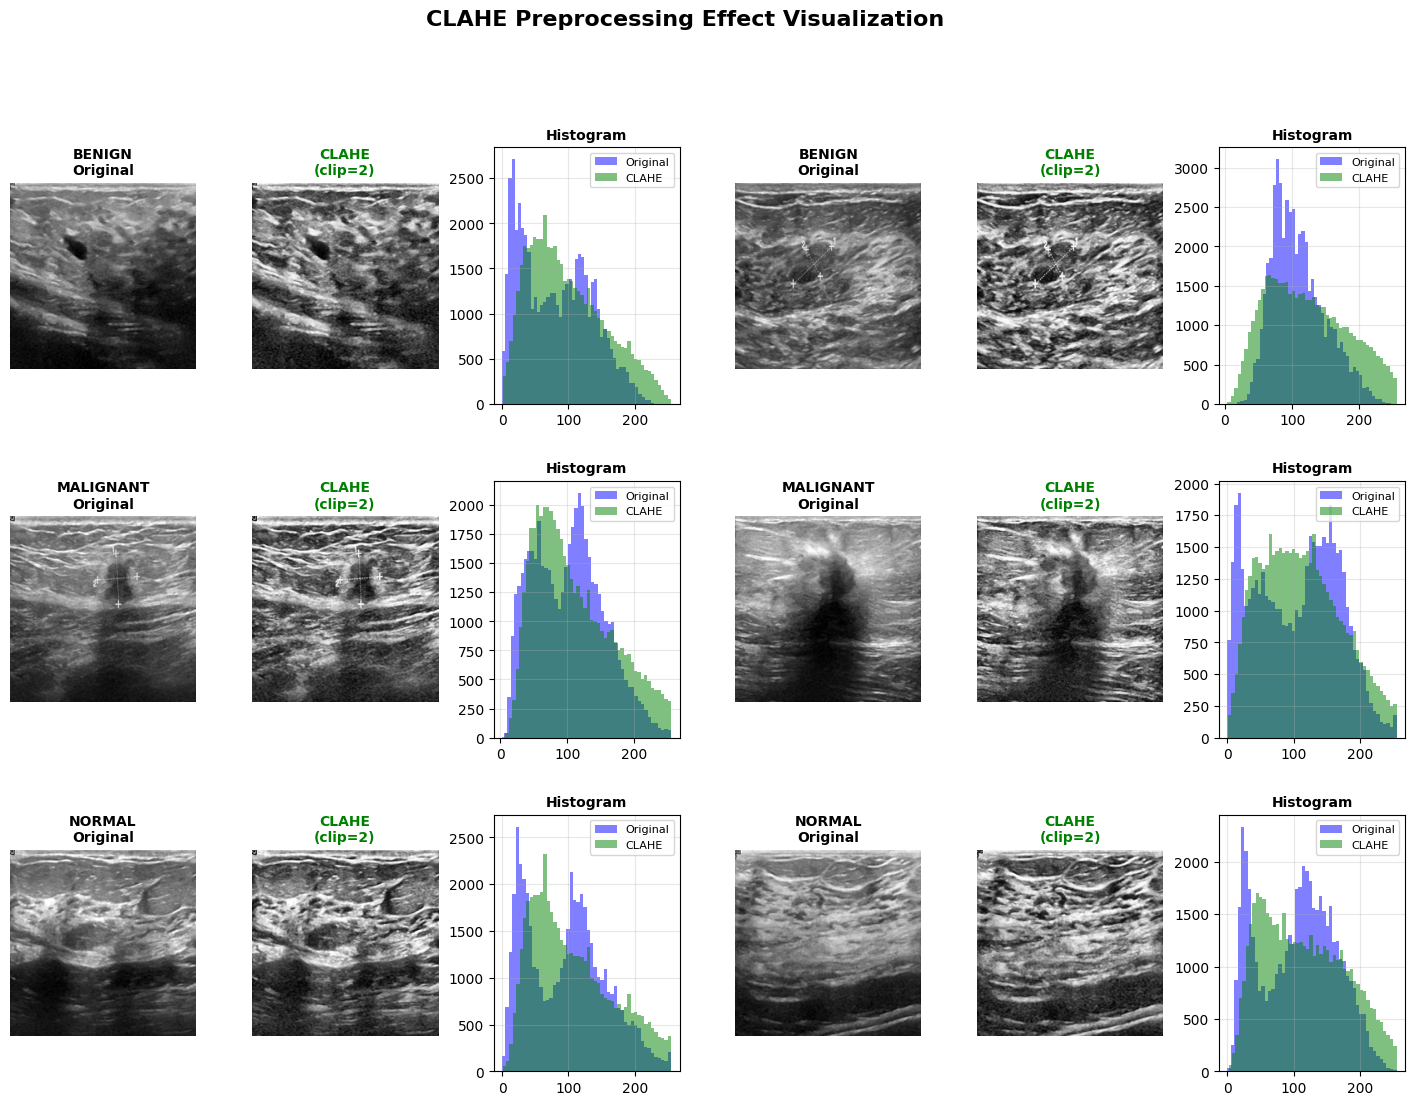

✅ CLAHE visualization saved as 'clahe_visualization.png'


In [12]:
# Visualize CLAHE effect on sample images
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 6, figure=fig, hspace=0.3, wspace=0.3)

for class_idx, class_name in enumerate(CLASSES):
    # Get 2 random samples from this class
    class_paths = [p for p, l in zip(paths_train, y_train) if l == label_to_index[class_name]]
    sample_paths = random.sample(class_paths, 2)
    
    for sample_idx, img_path in enumerate(sample_paths):
        # Load original image
        original = Image.open(img_path).convert('RGB')
        original_resized = original.resize(IMG_SIZE)
        
        # Apply CLAHE
        clahe_img = apply_clahe(original_resized)
        
        col_offset = sample_idx * 3
        
        # Original
        ax1 = fig.add_subplot(gs[class_idx, col_offset])
        ax1.imshow(original_resized)
        ax1.set_title(f"{class_name.upper()}\nOriginal", fontsize=10, fontweight='bold')
        ax1.axis('off')
        
        # CLAHE
        ax2 = fig.add_subplot(gs[class_idx, col_offset + 1])
        ax2.imshow(clahe_img)
        ax2.set_title(f"CLAHE\n(clip={CLAHE_CLIP})", fontsize=10, fontweight='bold', color='green')
        ax2.axis('off')
        
        # Difference/Histogram
        ax3 = fig.add_subplot(gs[class_idx, col_offset + 2])
        # Convert to grayscale for histogram
        original_gray = np.array(original_resized.convert('L'))
        clahe_gray = np.array(clahe_img.convert('L'))
        
        ax3.hist(original_gray.ravel(), bins=50, alpha=0.5, label='Original', color='blue')
        ax3.hist(clahe_gray.ravel(), bins=50, alpha=0.5, label='CLAHE', color='green')
        ax3.set_title("Histogram", fontsize=10, fontweight='bold')
        ax3.legend(fontsize=8)
        ax3.grid(alpha=0.3)

fig.suptitle('CLAHE Preprocessing Effect Visualization', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('clahe_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ CLAHE visualization saved as 'clahe_visualization.png'")

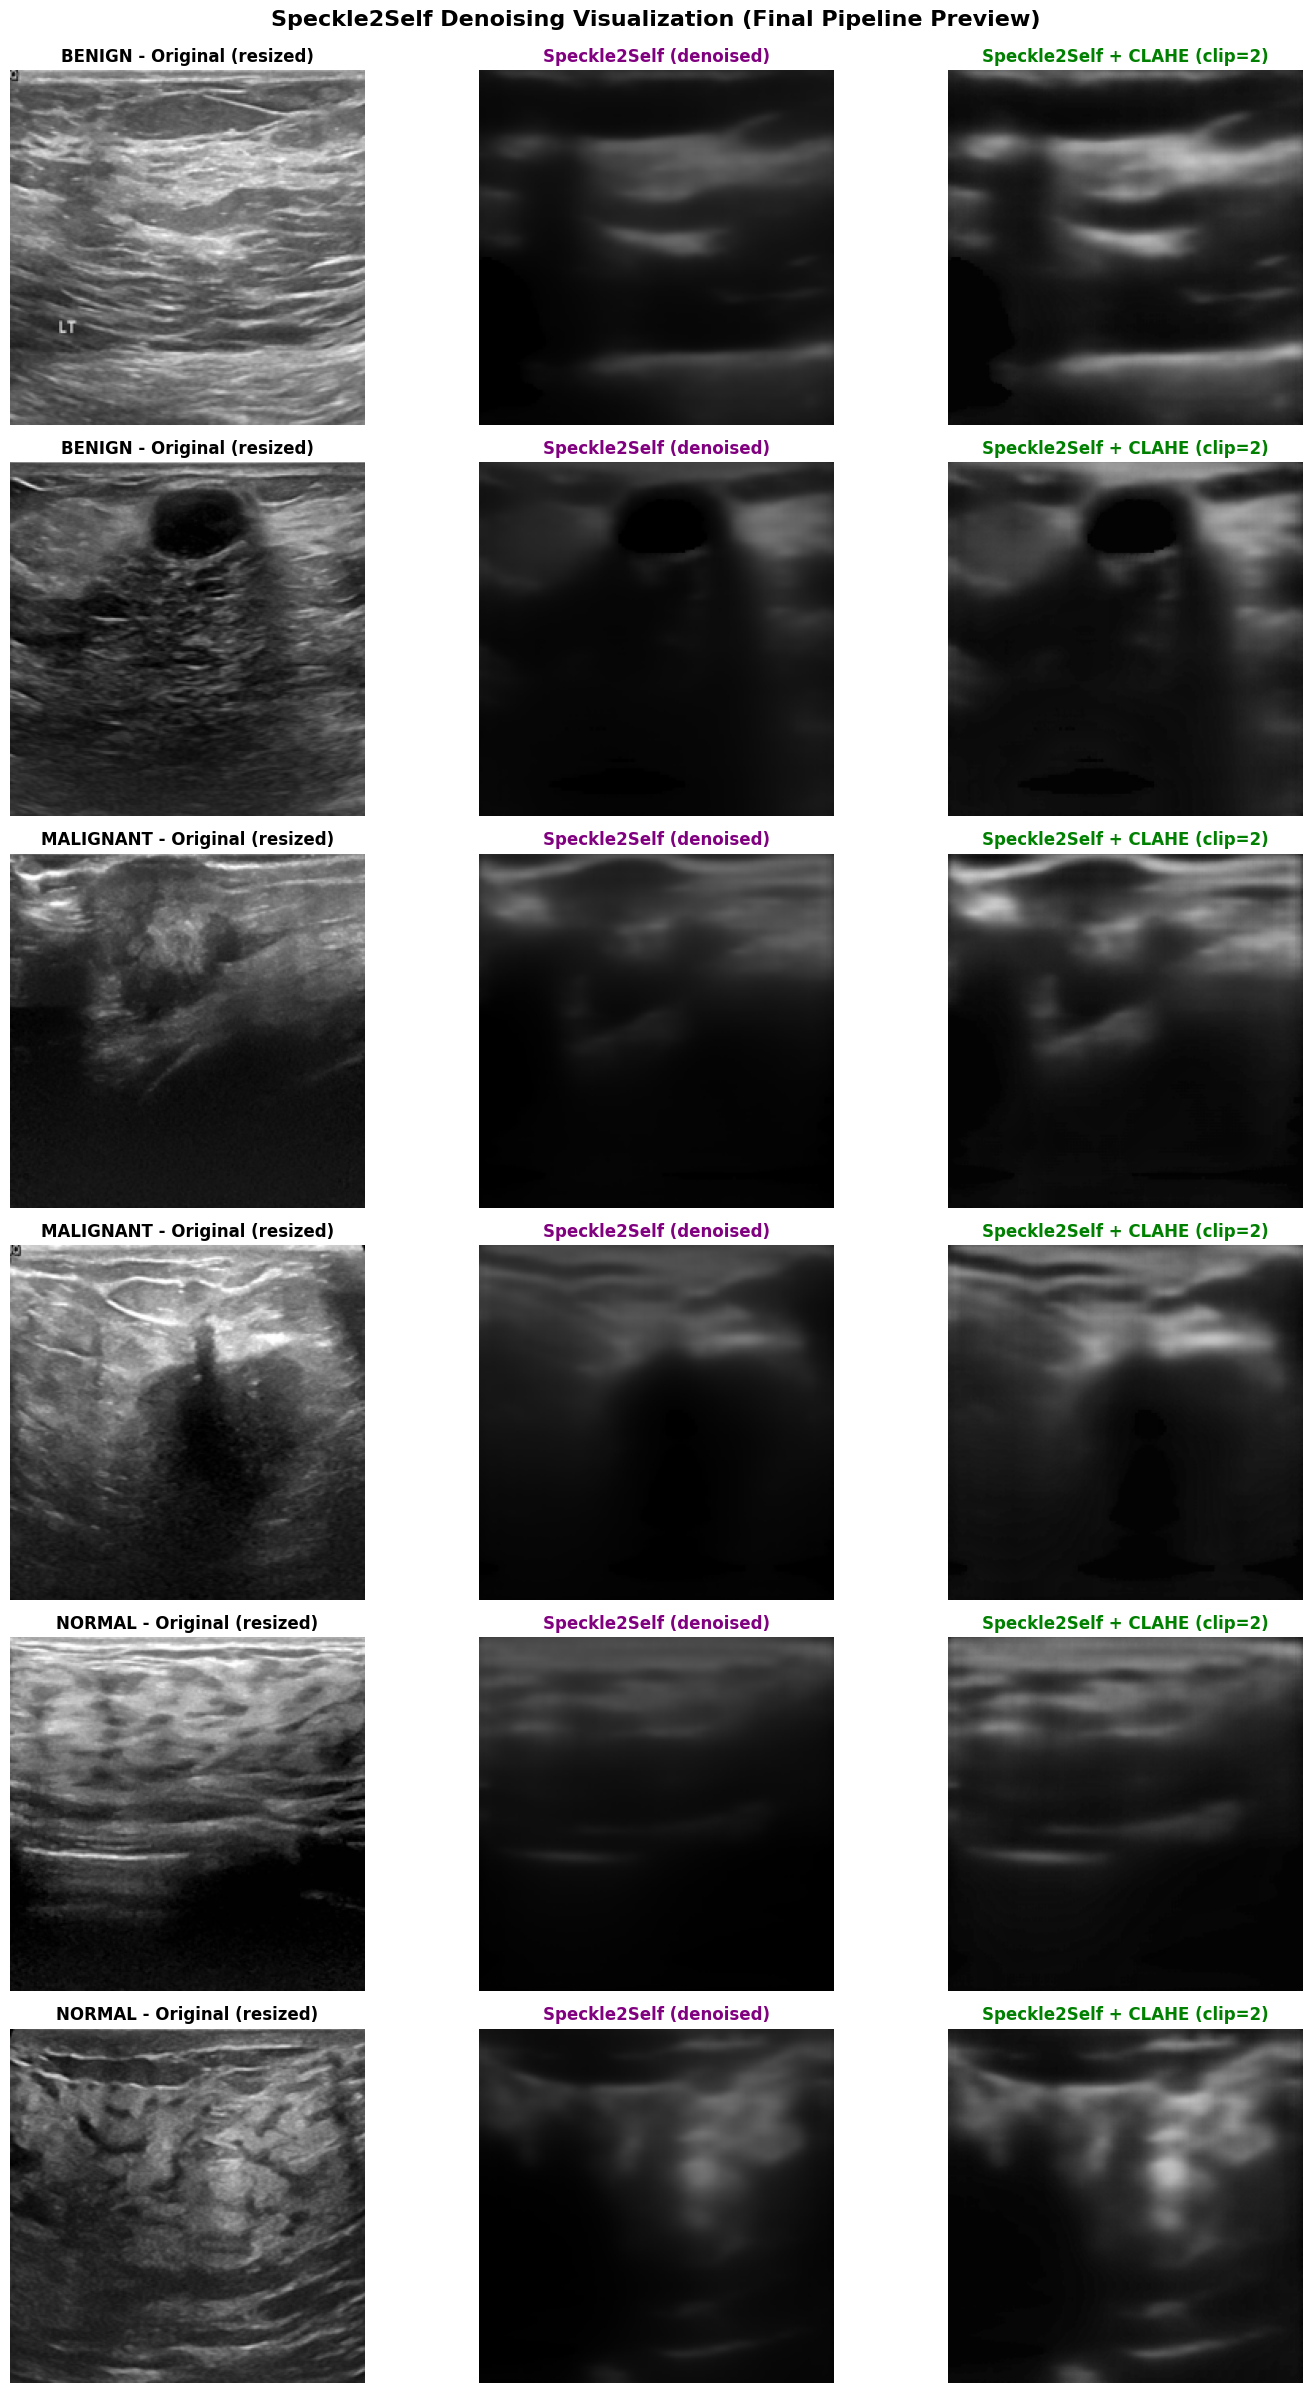

✅ Speckle2Self visualization rendered
✅ Saved PNG: F:\Kuliah Salsa\Humic\salsabila_humic\salsabila_humic\Speckle-Preprocessing-USG\speckle2self_visualization_final_pipeline.png


In [13]:
# Visualize Speckle2Self effect on sample images (after resize)
from pathlib import Path

def _pick_random_images_per_class(n_per_class=2, seed=RANDOM_SEED):
    rng = random.Random(seed)
    samples = []
    for class_name in CLASSES:
        class_dir = Path(DATASET_PATH) / class_name
        if not class_dir.exists():
            print(f"⚠️  Missing folder: {class_dir}")
            continue
        files = [p for p in class_dir.iterdir() if p.is_file() and 'mask' not in p.name.lower()]
        if len(files) == 0:
            print(f"⚠️  No images found in: {class_dir}")
            continue
        k = min(n_per_class, len(files))
        samples.extend([(class_name, p) for p in rng.sample(files, k)])
    return samples

# Guardrails: only run if repo + checkpoint exist
repo_path = Path(S2S_REPO_DIR)
ckpt_path = Path(S2S_MODEL_PATH)
if not repo_path.exists():
    print("ℹ️ Speckle2Self repo belum ada.")
    print(f"   Jalankan cell setup Speckle2Self, atau clone: git clone {S2S_REPO_URL} {S2S_REPO_DIR}")
elif not ckpt_path.exists():
    print("ℹ️ Checkpoint Speckle2Self belum ditemukan.")
    print(f"   Set S2S_MODEL_PATH ke file .pth yang kompatibel. Sekarang: {ckpt_path.resolve()}")
else:
    # Temporarily enable Speckle2Self for visualization (without changing your training config permanently)
    _prev_enabled = S2S_ENABLED
    try:
        if not S2S_ENABLED:
            S2S_ENABLED = True
        
        samples = _pick_random_images_per_class(n_per_class=2)
        if len(samples) == 0:
            raise RuntimeError("No sample images found to visualize.")
        
        n = len(samples)
        fig, axes = plt.subplots(n, 3, figsize=(15, 4 * n))
        if n == 1:
            axes = np.array([axes])
        
        for row, (class_name, img_path) in enumerate(samples):
            original = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
            denoised = apply_speckle2self(original, img_path=str(img_path))
            final_pipeline = apply_clahe(denoised, CLAHE_CLIP, CLAHE_GRID)
            
            axes[row, 0].imshow(original)
            axes[row, 0].set_title(f"{class_name.upper()} - Original (resized)", fontweight='bold')
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(denoised)
            axes[row, 1].set_title("Speckle2Self (denoised)", fontweight='bold', color='purple')
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(final_pipeline)
            axes[row, 2].set_title(f"Speckle2Self + CLAHE (clip={CLAHE_CLIP})", fontweight='bold', color='green')
            axes[row, 2].axis('off')
        
        fig.suptitle('Speckle2Self Denoising Visualization (Final Pipeline Preview)', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Save to PNG
        out_file = Path('speckle2self_visualization_final_pipeline.png')
        plt.savefig(out_file, dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Speckle2Self visualization rendered")
        print(f"✅ Saved PNG: {out_file.resolve()}")
    finally:
        S2S_ENABLED = _prev_enabled

## 5. Custom Dataset Class

In [14]:
class BreastCancerDataset(Dataset):
    """
    Custom Dataset for Breast Cancer Classification
    Supports optional Speckle2Self preprocessing and data augmentation
    """
    def __init__(self, image_paths, labels, transform=None, apply_clahe_preprocess=False, apply_s2s_preprocess=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.apply_clahe_preprocess = apply_clahe_preprocess
        self.apply_s2s_preprocess = apply_s2s_preprocess
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Resize
        image = image.resize(IMG_SIZE)
        
        # Apply Speckle2Self denoising (optional)
        if self.apply_s2s_preprocess:
            image = apply_speckle2self(image, img_path=img_path)
        
        # Apply CLAHE preprocessing (optional)
        if self.apply_clahe_preprocess:
            image = apply_clahe(image, CLAHE_CLIP, CLAHE_GRID)
        
        # Apply transforms (augmentation + normalization)
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

print("✅ Custom Dataset class defined")

✅ Custom Dataset class defined


## 6. Data Augmentation & Transforms

In [15]:
# Training transforms (with augmentation)
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5 if AUG_H_FLIP else 0),
    v2.RandomVerticalFlip(p=0.5 if AUG_V_FLIP else 0),
    v2.RandomAffine(
        degrees=AUG_ROTATION,
        translate=(AUG_W_SHIFT, AUG_H_SHIFT),
        scale=(1-AUG_ZOOM, 1+AUG_ZOOM) if AUG_ZOOM > 0 else None,
    ),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Validation/Test transforms (no augmentation)
val_test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Data transforms defined")
print(f"   - Horizontal Flip: {AUG_H_FLIP}")
print(f"   - Vertical Flip: {AUG_V_FLIP}")
print(f"   - Translation: ({AUG_W_SHIFT}, {AUG_H_SHIFT})")
print(f"   - Rotation: {AUG_ROTATION}°")

✅ Data transforms defined
   - Horizontal Flip: True
   - Vertical Flip: False
   - Translation: (0.05, 0.05)
   - Rotation: 0°


In [16]:
# Create datasets
train_dataset = BreastCancerDataset(
    paths_train, y_train, 
    transform=train_transforms, 
    apply_clahe_preprocess=USE_CLAHE,
    apply_s2s_preprocess=S2S_ENABLED,
 )

val_dataset = BreastCancerDataset(
    paths_val, y_val, 
    transform=val_test_transforms, 
    apply_clahe_preprocess=USE_CLAHE,
    apply_s2s_preprocess=S2S_ENABLED,
 )

test_dataset = BreastCancerDataset(
    paths_test, y_test, 
    transform=val_test_transforms, 
    apply_clahe_preprocess=USE_CLAHE,
    apply_s2s_preprocess=S2S_ENABLED,
 )

print(f"✅ Datasets created:")
print(f"   - Train: {len(train_dataset)} samples")
print(f"   - Val:   {len(val_dataset)} samples")
print(f"   - Test:  {len(test_dataset)} samples")
print(f"   - Speckle2Self enabled: {S2S_ENABLED}")
print(f"   - CLAHE enabled: {USE_CLAHE}")

✅ Datasets created:
   - Train: 823 samples
   - Val:   104 samples
   - Test:  103 samples
   - Speckle2Self enabled: True
   - CLAHE enabled: False


In [17]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print(f"✅ DataLoaders created:")
print(f"   - Train batches: {len(train_loader)}")
print(f"   - Val batches:   {len(val_loader)}")
print(f"   - Test batches:  {len(test_loader)}")

✅ DataLoaders created:
   - Train batches: 26
   - Val batches:   4
   - Test batches:  4


✅ speckle2self repo ready: F:\Kuliah Salsa\Humic\salsabila_humic\salsabila_humic\Speckle-Preprocessing-USG\speckle2self
✅ Speckle2Self model loaded: F:\Kuliah Salsa\Humic\salsabila_humic\salsabila_humic\Speckle-Preprocessing-USG\model_2833.pth


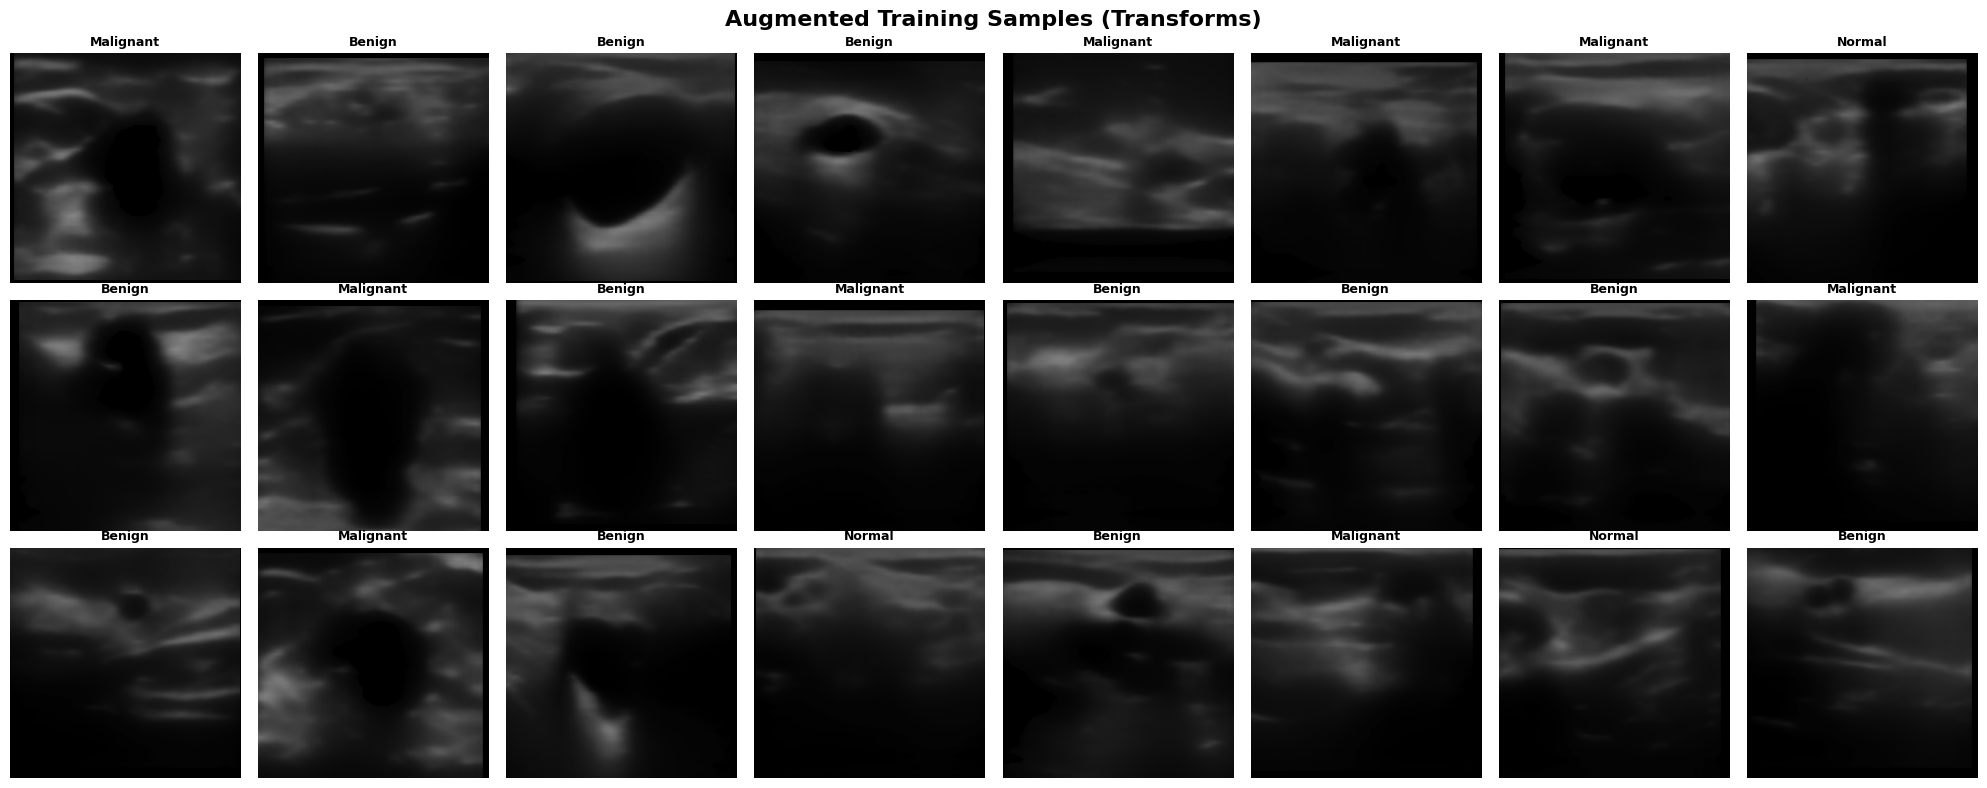

✅ Augmentation visualization saved as 'augmentation_samples.png'


In [18]:
# Visualize augmentation effects
def denormalize(tensor):
    """Denormalize tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = tensor * std + mean
    
    # For grayscale images converted to RGB (Speckle2Self output), average channels for natural look
    # Check if image is actually grayscale (all channels very similar)
    if torch.allclose(denorm[0], denorm[1], atol=0.01) and torch.allclose(denorm[1], denorm[2], atol=0.01):
        gray_avg = denorm.mean(dim=0, keepdim=True)
        denorm = gray_avg.repeat(3, 1, 1)
    
    return denorm

# Get a batch of training data
sample_images, sample_labels = next(iter(train_loader))

# Visualize
fig, axes = plt.subplots(3, 8, figsize=(20, 8))
fig.suptitle('Augmented Training Samples (Transforms)', fontsize=16, fontweight='bold')

for idx in range(min(24, len(sample_images))):
    row = idx // 8
    col = idx % 8
    
    img = denormalize(sample_images[idx]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    label_name = index_to_label[sample_labels[idx].item()]
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(label_name.capitalize(), fontsize=9, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('augmentation_samples.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Augmentation visualization saved as 'augmentation_samples.png'")

## 7. Model Architecture - DenseNet201

**DenseNet121 Architecture:**
- Dense connections: setiap layer terhubung ke semua layer sebelumnya
- Feature reuse: efficient feature propagation
- Fewer parameters: dibanding model dengan depth yang sama
- Strong gradient flow: memudahkan training

**Transfer Learning Strategy:**
- Pretrained on ImageNet
- Freeze 90% of layers (only last 10% trainable)
- Custom classifier head with dropout and L2 regularization

In [22]:
class DenseNet201Classifier(pl.LightningModule):
    """
    DenseNet201 model for Breast Cancer Classification
    with PyTorch Lightning - Matching TensorFlow architecture
    """
    def __init__(self, num_classes=3, learning_rate=1e-4, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pretrained DenseNet201
        weights = DenseNet201_Weights.IMAGENET1K_V1
        base_model = densenet201(weights=weights)
        
        # Extract features (remove classifier)
        self.features = base_model.features
        
        # Freeze layers (freeze first 90%, train last 10%)
        total_params = len(list(self.features.parameters()))
        freeze_until = int(total_params * (1 - FREEZE_PERCENTAGE))
        
        for idx, param in enumerate(self.features.parameters()):
            if idx < freeze_until:
                param.requires_grad = False
        
        # Get number of features
        num_features = base_model.classifier.in_features
        
        # Build classifier head to match TensorFlow architecture:
        # GlobalAveragePooling2D -> BatchNorm -> Dropout ->
        # Dense(256) -> BatchNorm -> Dropout -> Dense(num_classes)
        self.classifier = nn.Sequential(
            # Global Average Pooling is done in forward()
            nn.BatchNorm1d(num_features),  # After pooling
            nn.Dropout(DROPOUT_RATE),
            
            # Dense layer with equivalent of L2 regularization
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # After Dense
            nn.Dropout(DROPOUT_RATE),
            
            # Output layer (no softmax, handled by CrossEntropyLoss)
            nn.Linear(256, num_classes)
        )
        
        # Loss function with class weights
        if class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss()
        
        # Metrics
        self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        
        # Store predictions for confusion matrix
        self.validation_step_outputs = []
        self.test_step_outputs = []
    
    def forward(self, x):
        # Extract features
        features = self.features(x)
        
        # Global Average Pooling (equivalent to TensorFlow's GlobalAveragePooling2D)
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features, 1)
        
        # Classification head
        output = self.classifier(features)
        return output
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        
        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        acc = self.train_accuracy(preds, labels)
        f1 = self.train_f1(preds, labels)
        
        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        
        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        acc = self.val_accuracy(preds, labels)
        f1 = self.val_f1(preds, labels)
        
        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True)
        
        # Store for confusion matrix
        self.validation_step_outputs.append({'preds': preds, 'labels': labels})
        
        return loss
    
    def on_validation_epoch_end(self):
        # Clear stored outputs
        self.validation_step_outputs.clear()
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        
        preds = torch.argmax(outputs, dim=1)
        self.test_step_outputs.append({'preds': preds, 'labels': labels})
        
        return {'preds': preds, 'labels': labels}
    
    def configure_optimizers(self):
        # Adam optimizer with L2 regularization (weight_decay)
        # This is equivalent to kernel_regularizer=l2(L2_RATE) in TensorFlow
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.hparams.learning_rate,
            weight_decay=L2_RATE
        )
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

print("✅ DenseNet201 model class defined (matching TensorFlow architecture)")

✅ DenseNet201 model class defined (matching TensorFlow architecture)


In [23]:
# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"\n{'='*50}")
print(f"{'CLASS WEIGHTS (for imbalanced data)':^50}")
print(f"{'='*50}")
for idx, (label, weight) in enumerate(zip(CLASSES, class_weights)):
    print(f"{label.capitalize():12s}: {weight:.4f}")
print(f"{'='*50}\n")


       CLASS WEIGHTS (for imbalanced data)        
Benign      : 0.6395
Malignant   : 0.9525
Normal      : 2.5881



In [ ]:
# Create model instance
model = DenseNet201Classifier(
    num_classes=num_classes,
    learning_rate=LEARNING_RATE,
    class_weights=class_weights
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\n{'='*60}")
print(f"{'MODEL SUMMARY - DenseNet201':^60}")
print(f"{'='*60}")
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"Frozen parameters:    {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
print(f"\nModel Configuration:")
print(f"  - Freeze Percentage: {FREEZE_PERCENTAGE*100:.0f}%")
print(f"  - Dropout Rate:      {DROPOUT_RATE}")
print(f"  - L2 Regularization: {L2_RATE}")
print(f"  - Learning Rate:     {LEARNING_RATE}")
print(f"{'='*60}\n")

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\salsabilaara/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
 18%|█████████████▋                                                                | 13.6M/77.4M [00:35<01:39, 669kB/s]

## 8. Training

In [ ]:
# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    filename='densenet201-{epoch:02d}-{val_f1:.4f}',
    monitor='val_f1',
    mode='max',
    save_top_k=3,
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor='val_f1',
    patience=EARLY_STOPPING_PATIENCE,
    mode='max',
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Setup logger
csv_logger = CSVLogger('logs/', name='densenet201_clahe')

print("✅ Callbacks and logger configured")

In [ ]:
# Create trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    logger=csv_logger,
    log_every_n_steps=10,
    deterministic=True,
    precision='16-mixed' if torch.cuda.is_available() else '32'
)

print("✅ Trainer initialized")
print(f"   - Max epochs: {EPOCHS}")
print(f"   - Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"   - Precision: {'16-mixed' if torch.cuda.is_available() else '32'}")

In [ ]:
# Train the model
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60 + "\n")

start_time = time.time()

trainer.fit(model, train_loader, val_loader)

training_time = time.time() - start_time

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Best model saved at: {checkpoint_callback.best_model_path}")
print(f"Best val_f1: {checkpoint_callback.best_model_score:.4f}")
print("="*60 + "\n")

## 9. Training Results Visualization

In [ ]:
# Load training metrics
metrics_path = os.path.join(csv_logger.log_dir, 'metrics.csv')
metrics_df = pd.read_csv(metrics_path)

# Clean the data (remove NaN rows)
train_metrics = metrics_df[['epoch', 'train_loss', 'train_acc', 'train_f1']].dropna()
val_metrics = metrics_df[['epoch', 'val_loss', 'val_acc', 'val_f1']].dropna()

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(train_metrics['epoch'], train_metrics['train_loss'], 
             label='Train Loss', marker='o', linewidth=2, markersize=4, color='#3498db')
axes[0].plot(val_metrics['epoch'], val_metrics['val_loss'], 
             label='Val Loss', marker='s', linewidth=2, markersize=4, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_metrics['epoch'], train_metrics['train_acc'], 
             label='Train Accuracy', marker='o', linewidth=2, markersize=4, color='#3498db')
axes[1].plot(val_metrics['epoch'], val_metrics['val_acc'], 
             label='Val Accuracy', marker='s', linewidth=2, markersize=4, color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(train_metrics['epoch'], train_metrics['train_f1'], 
             label='Train F1', marker='o', linewidth=2, markersize=4, color='#3498db')
axes[2].plot(val_metrics['epoch'], val_metrics['val_f1'], 
             label='Val F1', marker='s', linewidth=2, markersize=4, color='#e74c3c')
axes[2].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[2].set_title('Training & Validation F1 Score', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Training history saved as 'training_history.png'")

# Print final metrics
print(f"\n{'='*60}")
print(f"{'FINAL TRAINING METRICS':^60}")
print(f"{'='*60}")
print(f"Final Train Loss: {train_metrics['train_loss'].iloc[-1]:.4f}")
print(f"Final Train Acc:  {train_metrics['train_acc'].iloc[-1]:.4f}")
print(f"Final Train F1:   {train_metrics['train_f1'].iloc[-1]:.4f}")
print(f"-" * 60)
print(f"Final Val Loss:   {val_metrics['val_loss'].iloc[-1]:.4f}")
print(f"Final Val Acc:    {val_metrics['val_acc'].iloc[-1]:.4f}")
print(f"Final Val F1:     {val_metrics['val_f1'].iloc[-1]:.4f}")
print(f"{'='*60}\n")

## 10. Model Evaluation on Test Set

In [ ]:
# Load best model
best_model = DenseNet201Classifier.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    num_classes=num_classes,
    learning_rate=LEARNING_RATE,
    class_weights=class_weights
)
best_model.eval()
best_model.to(device)

print(f"✅ Best model loaded from: {checkpoint_callback.best_model_path}")

In [ ]:
# Get predictions on test set
print("🧪 Evaluating on test set...")

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = best_model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("✅ Test predictions completed")

In [ ]:
# Calculate test metrics
test_f1_macro = f1_score(all_labels, all_preds, average='macro')
test_f1_weighted = f1_score(all_labels, all_preds, average='weighted')
test_accuracy = np.mean(all_preds == all_labels)

# Classification report
print(f"\n{'='*60}")
print(f"{'TEST SET RESULTS':^60}")
print(f"{'='*60}")
print(f"Test Accuracy:        {test_accuracy:.4f}")
print(f"Test F1 (Macro):      {test_f1_macro:.4f} ⭐")
print(f"Test F1 (Weighted):   {test_f1_weighted:.4f}")
print(f"{'='*60}\n")

print("Classification Report:")
print(classification_report(
    all_labels, all_preds, 
    target_names=CLASSES,
    digits=4
))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c.capitalize() for c in CLASSES],
            yticklabels=[c.capitalize() for c in CLASSES],
            ax=axes[0], cbar_kws={'label': 'Count'},
            linewidths=1, linecolor='black')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=[c.capitalize() for c in CLASSES],
            yticklabels=[c.capitalize() for c in CLASSES],
            ax=axes[1], cbar_kws={'label': 'Percentage'},
            linewidths=1, linecolor='black', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
# Per-class metrics visualization
from sklearn.metrics import precision_score, recall_score

precision_per_class = precision_score(all_labels, all_preds, average=None)
recall_per_class = recall_score(all_labels, all_preds, average=None)
f1_per_class = f1_score(all_labels, all_preds, average=None)

# Create DataFrame for visualization
metrics_df = pd.DataFrame({
    'Class': [c.capitalize() for c in CLASSES],
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(CLASSES))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', 
               color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, recall_per_class, width, label='Recall', 
               color='#2ecc71', edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', 
               color='#e74c3c', edgecolor='black', linewidth=1.5)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.capitalize() for c in CLASSES])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Per-class metrics saved as 'per_class_metrics.png'")

print("\nPer-Class Metrics Table:")
print(metrics_df.to_string(index=False))

In [ ]:
# Visualize sample predictions
def visualize_predictions(num_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    # Get random samples
    indices = random.sample(range(len(paths_test)), num_samples)
    
    for idx, img_idx in enumerate(indices):
        # Load and process image
        img_path = paths_test[img_idx]
        image = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
        image_clahe = apply_clahe(image)
        
        # Get prediction
        input_tensor = val_test_transforms(image_clahe).unsqueeze(0).to(device)
        with torch.no_grad():
            output = best_model(input_tensor)
            probs = F.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            confidence = probs[0, pred_class].item()
        
        true_class = y_test[img_idx]
        
        # Plot
        axes[idx].imshow(image_clahe)
        
        # Title with prediction
        true_label = index_to_label[true_class].capitalize()
        pred_label = index_to_label[pred_class].capitalize()
        
        if pred_class == true_class:
            color = 'green'
            mark = '✓'
        else:
            color = 'red'
            mark = '✗'
        
        title = f"{mark} True: {true_label}\nPred: {pred_label} ({confidence:.2%})"
        axes[idx].set_title(title, fontsize=10, fontweight='bold', color=color)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Sample predictions saved as 'sample_predictions.png'")

visualize_predictions(12)

## 11. Explainable AI - Grad-CAM

**Grad-CAM (Gradient-weighted Class Activation Mapping)**:
- Visualisasi area penting yang digunakan model untuk prediksi
- Menggunakan gradients dari target class
- Menghasilkan heatmap yang menunjukkan region of interest
- Membantu memahami keputusan model (interpretability)

In [ ]:
class GradCAM:
    """
    Grad-CAM implementation for visualization
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        model_output = self.model(input_tensor)
        
        if target_class is None:
            target_class = model_output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        class_loss = model_output[0, target_class]
        class_loss.backward()
        
        # Generate CAM
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]
        
        # Global average pooling on gradients
        weights = torch.mean(gradients, dim=(1, 2))  # [C]
        
        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=input_tensor.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # ReLU
        cam = F.relu(cam)
        
        # Normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy()

print("✅ Grad-CAM class defined")

In [ ]:
target_layer = best_model.features[-1]  # Last layer of features (norm5)
grad_cam = GradCAM(best_model, target_layer)

print("✅ Grad-CAM initialized with target layer:", target_layer.__class__.__name__)
print(f"Target layer: {target_layer}")

In [ ]:
def visualize_gradcam(img_path, true_label, save_name=None):
    """
    Visualize Grad-CAM for a single image
    """
    # Load and preprocess image
    image = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
    image_clahe = apply_clahe(image)
    
    # Prepare input tensor
    input_tensor = val_test_transforms(image_clahe).unsqueeze(0).to(device)
    
    # Get prediction
    best_model.eval()
    with torch.no_grad():
        output = best_model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()
    
    # Generate Grad-CAM
    cam = grad_cam.generate_cam(input_tensor, pred_class)
    cam_resized = cv2.resize(cam, IMG_SIZE)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # CLAHE processed
    axes[1].imshow(image_clahe)
    axes[1].set_title('CLAHE Processed', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Grad-CAM heatmap
    axes[2].imshow(cam_resized, cmap='jet')
    axes[2].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # Overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.uint8(0.5 * np.array(image_clahe) + 0.5 * heatmap)
    axes[3].imshow(overlay)
    axes[3].set_title('Grad-CAM Overlay', fontsize=12, fontweight='bold')
    axes[3].axis('off')
    
    # Main title
    true_name = index_to_label[true_label].capitalize()
    pred_name = index_to_label[pred_class].capitalize()
    
    if pred_class == true_label:
        result = "✓ CORRECT"
        color = 'green'
    else:
        result = "✗ INCORRECT"
        color = 'red'
    
    fig.suptitle(
        f"{result} | True: {true_name} | Predicted: {pred_name} ({confidence:.2%})",
        fontsize=14, fontweight='bold', color=color
    )
    
    plt.tight_layout()
    
    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    plt.show()

print("✅ Grad-CAM visualization function defined")

In [ ]:
# Generate Grad-CAM for sample images from each class
print("🔥 Generating Grad-CAM visualizations...\n")

for class_idx, class_name in enumerate(CLASSES):
    # Get samples from this class
    class_indices = np.where(y_test == class_idx)[0]
    
    if len(class_indices) > 0:
        # Get 2 random samples
        sample_indices = random.sample(list(class_indices), min(2, len(class_indices)))
        
        for i, idx in enumerate(sample_indices):
            img_path = paths_test[idx]
            true_label = y_test[idx]
            
            print(f"Class: {class_name.upper()} - Sample {i+1}")
            visualize_gradcam(
                img_path, 
                true_label, 
                save_name=f'gradcam_{class_name}_{i+1}.png'
            )

print("\n✅ All Grad-CAM visualizations generated and saved!")

In [ ]:
# Create a comprehensive Grad-CAM grid
fig = plt.figure(figsize=(24, 18))
gs = GridSpec(3, 8, figure=fig, hspace=0.4, wspace=0.3)

for class_idx, class_name in enumerate(CLASSES):
    # Get samples from this class
    class_indices = np.where(y_test == class_idx)[0]
    sample_indices = random.sample(list(class_indices), min(2, len(class_indices)))
    
    for sample_idx, idx in enumerate(sample_indices):
        img_path = paths_test[idx]
        
        # Load and process
        image = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
        image_clahe = apply_clahe(image)
        input_tensor = val_test_transforms(image_clahe).unsqueeze(0).to(device)
        
        # Predict and generate CAM
        with torch.no_grad():
            output = best_model(input_tensor)
            pred_class = torch.argmax(output, dim=1).item()
        
        cam = grad_cam.generate_cam(input_tensor, pred_class)
        cam_resized = cv2.resize(cam, IMG_SIZE)
        
        # Create overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = np.uint8(0.5 * np.array(image_clahe) + 0.5 * heatmap)
        
        col_offset = sample_idx * 4
        
        # Original
        ax1 = fig.add_subplot(gs[class_idx, col_offset])
        ax1.imshow(image)
        ax1.set_title(f"{class_name.upper()}\nOriginal", fontsize=9, fontweight='bold')
        ax1.axis('off')
        
        # CLAHE
        ax2 = fig.add_subplot(gs[class_idx, col_offset + 1])
        ax2.imshow(image_clahe)
        ax2.set_title("CLAHE", fontsize=9, fontweight='bold')
        ax2.axis('off')
        
        # Grad-CAM
        ax3 = fig.add_subplot(gs[class_idx, col_offset + 2])
        ax3.imshow(cam_resized, cmap='jet')
        ax3.set_title("Grad-CAM", fontsize=9, fontweight='bold')
        ax3.axis('off')
        
        # Overlay
        ax4 = fig.add_subplot(gs[class_idx, col_offset + 3])
        ax4.imshow(overlay)
        ax4.set_title("Overlay", fontsize=9, fontweight='bold')
        ax4.axis('off')

fig.suptitle('Comprehensive Grad-CAM Visualization Grid', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('gradcam_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Comprehensive Grad-CAM grid saved as 'gradcam_comprehensive.png'")

## 12. Final Summary

In [ ]:
# Create comprehensive summary
summary = f"""
{'='*70}
{'BREAST CANCER CLASSIFICATION - FINAL SUMMARY':^70}
{'='*70}

MODEL ARCHITECTURE:
  - Model:              DenseNet201 (Pretrained on ImageNet)
  - Total Parameters:   {total_params:,}
  - Trainable Params:   {trainable_params:,} ({trainable_params/total_params*100:.1f}%)
  - Freeze Strategy:    First {(1-FREEZE_PERCENTAGE)*100:.0f}% frozen

PREPROCESSING:
  - Method:             CLAHE (Contrast Limited Adaptive Histogram Equalization)
  - Clip Limit:         {CLAHE_CLIP}
  - Grid Size:          {CLAHE_GRID}

DATASET:
  - Total Images:       {len(image_paths)}
  - Training:           {len(paths_train)} ({len(paths_train)/len(image_paths)*100:.1f}%)
  - Validation:         {len(paths_val)} ({len(paths_val)/len(image_paths)*100:.1f}%)
  - Testing:            {len(paths_test)} ({len(paths_test)/len(image_paths)*100:.1f}%)
  - Classes:            {', '.join([c.capitalize() for c in CLASSES])}

TRAINING CONFIGURATION:
  - Epochs:             {EPOCHS}
  - Batch Size:         {BATCH_SIZE}
  - Learning Rate:      {LEARNING_RATE}
  - Optimizer:          Adam
  - Scheduler:          ReduceLROnPlateau
  - Dropout Rate:       {DROPOUT_RATE}
  - L2 Regularization:  {L2_RATE}
  - Early Stopping:     {EARLY_STOPPING_PATIENCE} epochs

DATA AUGMENTATION:
  - Horizontal Flip:    {AUG_H_FLIP}
  - Vertical Flip:      {AUG_V_FLIP}
  - Translation:        W={AUG_W_SHIFT}, H={AUG_H_SHIFT}
  - Rotation:           {AUG_ROTATION}°

BEST MODEL PERFORMANCE:
  - Checkpoint:         {os.path.basename(checkpoint_callback.best_model_path)}
  - Val F1 Score:       {checkpoint_callback.best_model_score:.4f}

{'='*70}
{'TEST SET RESULTS (FINAL EVALUATION)':^70}
{'='*70}
  ⭐ TEST F1 (MACRO):   {test_f1_macro:.4f}
  - Test F1 (Weighted): {test_f1_weighted:.4f}
  - Test Accuracy:      {test_accuracy:.4f}

PER-CLASS F1 SCORES:
"""

for class_name, f1 in zip(CLASSES, f1_per_class):
    summary += f"  - {class_name.capitalize():12s}: {f1:.4f}\n"

summary += f"""
{'='*70}

EXPLAINABLE AI:
  - Method:             Grad-CAM (Gradient-weighted Class Activation Mapping)
  - Target Layer:       Last DenseBlock layer
  - Visualizations:     Generated for all classes

GENERATED FILES:
  ✓ data_distribution.png         - Dataset split visualization
  ✓ clahe_visualization.png       - CLAHE preprocessing effects
  ✓ augmentation_samples.png      - Augmented training samples
  ✓ training_history.png          - Training metrics over epochs
  ✓ confusion_matrix.png          - Confusion matrices (raw & normalized)
  ✓ per_class_metrics.png         - Per-class performance comparison
  ✓ sample_predictions.png        - Sample predictions visualization
  ✓ gradcam_*.png                 - Individual Grad-CAM visualizations
  ✓ gradcam_comprehensive.png     - Comprehensive Grad-CAM grid
  ✓ Best model checkpoint         - Saved in checkpoints/

TRAINING TIME:
  - Total Time:         {training_time/60:.2f} minutes

{'='*70}
✅ ANALYSIS COMPLETE
{'='*70}
"""

print(summary)

# Save summary to file
with open('model_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✅ Summary saved as 'model_summary.txt'")

In [ ]:
# Save detailed results to JSON
results = {
    'model': 'DenseNet201',
    'preprocessing': 'CLAHE',
    'clahe_config': {
        'clip_limit': CLAHE_CLIP,
        'grid_size': CLAHE_GRID
    },
    'dataset': {
        'total': len(image_paths),
        'train': len(paths_train),
        'val': len(paths_val),
        'test': len(paths_test),
        'classes': CLASSES
    },
    'training_config': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'dropout': DROPOUT_RATE,
        'l2_regularization': L2_RATE,
        'freeze_percentage': FREEZE_PERCENTAGE
    },
    'test_results': {
        'f1_macro': float(test_f1_macro),
        'f1_weighted': float(test_f1_weighted),
        'accuracy': float(test_accuracy),
        'per_class_f1': {CLASSES[i]: float(f1_per_class[i]) for i in range(len(CLASSES))},
        'per_class_precision': {CLASSES[i]: float(precision_per_class[i]) for i in range(len(CLASSES))},
        'per_class_recall': {CLASSES[i]: float(recall_per_class[i]) for i in range(len(CLASSES))}
    },
    'confusion_matrix': cm.tolist(),
    'best_model_path': checkpoint_callback.best_model_path,
    'training_time_minutes': training_time / 60
}

with open('results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Detailed results saved as 'results.json'")

## 13. Conclusion

This notebook demonstrates:
1. ✅ **Data Preprocessing (Speckle2Self + CLAHE)** - Denoising + contrast enhancement for better feature extraction
2. ✅ **DenseNet121 Transfer Learning** - Leveraging pretrained features with fine-tuning
3. ✅ **Comprehensive Evaluation** - F1-score focused with detailed per-class metrics
4. ✅ **Explainable AI with Grad-CAM** - Visual interpretation of model decisions
5. ✅ **Complete Visualization Pipeline** - From preprocessing to final results

### Key Achievements:
- **Test F1-Score (Macro)**: Focus metric for model evaluation
- **Balanced Performance**: Across all three classes (benign, malignant, normal)
- **Interpretability**: Grad-CAM shows model's attention regions
- **Reproducibility**: All configurations documented and seeds set

### For Presentation:
All visualizations have been saved and can be used directly in PowerPoint:
- Dataset distribution and preprocessing effects
- Training history and metrics
- Confusion matrix and per-class performance
- Grad-CAM visualizations for explainability
- Speckle2Self preview: `speckle2self_visualization_final_pipeline.png`

---
**Made for Deep Learning Assignment**